In [4]:
using LinearAlgebra, Statistics
using Distributions, Interpolations, Expectations
using LaTeXStrings, Plots, NLsolve, Random

In [5]:
# model object
function JvWorker(; A = 1.4,
    alpha = 0.6,
    beta = 0.96,
    grid_size = 50,
    epsilon = 1e-4)
G(x, phi) = A .* (x .* phi) .^ alpha
pi_func = sqrt
F = Beta(2, 2)

# expectation operator
E = expectation(F)

# Set up grid over the state space for DP
# Max of grid is the max of a large quantile value for F and the
# fixed point y = G(y, 1).
grid_max = max(A^(1.0 / (1.0 - alpha)), quantile(F, 1 - epsilon))

# range for range(epsilon, grid_max, grid_size). Needed for
# CoordInterpGrid below
x_grid = range(epsilon, grid_max, length = grid_size)

return (; A, alpha, beta, x_grid, G,
pi_func, F, E, epsilon)
end

function T!(jv, V, new_V::AbstractVector)

# simplify notation
(; G, pi_func, F, beta, E, epsilon) = jv

# prepare interpoland of value function
Vf = LinearInterpolation(jv.x_grid, V, extrapolation_bc = Line())

# instantiate the linesearch variables
max_val = -1.0
cur_val = 0.0
max_s = 1.0
max_phi = 1.0
search_grid = range(epsilon, 1.0, length = 15)

for (i, x) in enumerate(jv.x_grid)
function w(z)
s, phi = z
h(u) = Vf(max(G(x, phi), u))
integral = E(h)
q = pi_func(s) * integral + (1.0 - pi_func(s)) * Vf(G(x, phi))

return -x * (1.0 - phi - s) - beta * q
end

for s in search_grid
for phi in search_grid
  cur_val = ifelse(s + phi <= 1.0, -w((s, phi)), -1.0)
  if cur_val > max_val
      max_val, max_s, max_phi = cur_val, s, phi
  end
end
end

new_V[i] = max_val
end
end

function T!(jv, V, out::Tuple{AbstractVector, AbstractVector})

# simplify notation
(; G, pi_func, F, beta, E, epsilon) = jv

# prepare interpoland of value function
Vf = LinearInterpolation(jv.x_grid, V, extrapolation_bc = Line())

# instantiate variables
s_policy, phi_policy = out[1], out[2]

# instantiate the linesearch variables
max_val = -1.0
cur_val = 0.0
max_s = 1.0
max_phi = 1.0
search_grid = range(epsilon, 1.0, length = 15)

for (i, x) in enumerate(jv.x_grid)
function w(z)
s, phi = z
h(u) = Vf(max(G(x, phi), u))
integral = E(h)
q = pi_func(s) * integral + (1.0 - pi_func(s)) * Vf(G(x, phi))

return -x * (1.0 - phi - s) - beta * q
end

for s in search_grid
for phi in search_grid
  cur_val = ifelse(s + phi <= 1.0, -w((s, phi)), -1.0)
  if cur_val > max_val
      max_val, max_s, max_phi = cur_val, s, phi
  end
end
end

s_policy[i], phi_policy[i] = max_s, max_phi
end
end

function T(jv, V; ret_policies = false)
out = ifelse(ret_policies, (similar(V), similar(V)), similar(V))
T!(jv, V, out)
return out
end

T (generic function with 1 method)

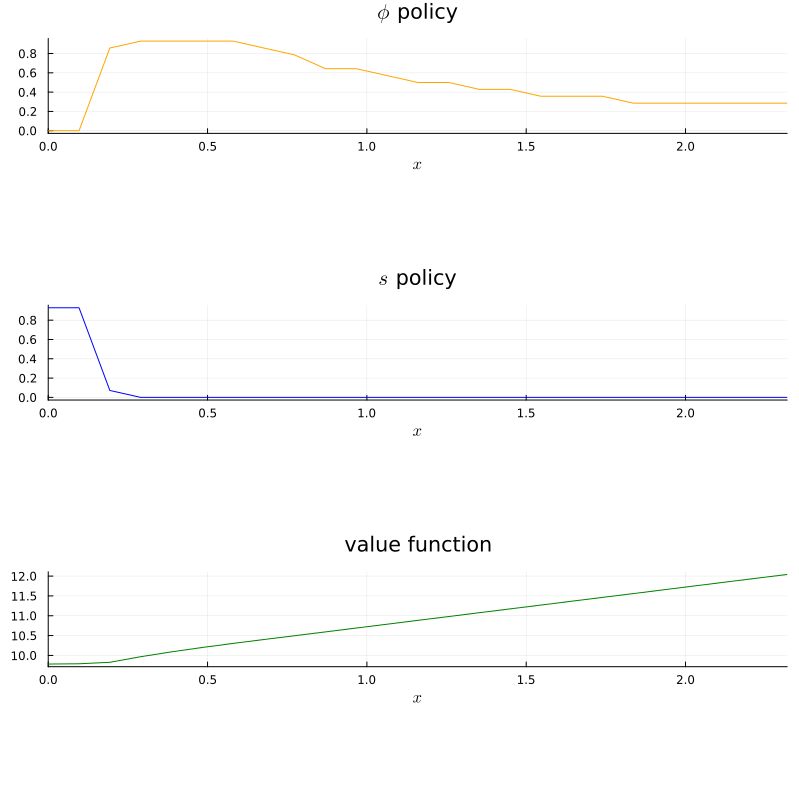

In [6]:
wp = JvWorker(grid_size = 25)
v_init = collect(wp.x_grid) .* 0.5

f(x) = T(wp, x)
V = fixedpoint(f, v_init)
sol_V = V.zero

s_policy, phi_policy = T(wp, sol_V, ret_policies = true)

# plot solution
p = plot(wp.x_grid, [phi_policy s_policy sol_V],
         title = [L"$\phi$ policy" L"$s$ policy" "value function"],
         color = [:orange :blue :green],
         xaxis = (L"x", (0.0, maximum(wp.x_grid))),
         yaxis = ((-0.1, 1.1)), size = (800, 800),
         legend = false, layout = (3, 1),
         bottom_margin = Plots.PlotMeasures.Length(:mm, 20))